#What is the optimal angle to maximize the distance of a ballistic trajectory

It's a well known fact that if you neglect air resistance when throwing a ball for example the best angle to maximize the distance is 45 degrees.
But that angle is best if we include a complicated dependence in the air resistance?
I use a complicated drag term and solve Newton's equation using a 4-order runge kutta. To find the the best angle is use an adaptive hillclimb to iterate angles from som starting angle.
It's adaptive since it changes the step length of the hillclimb if it has to change the direction of it search so as to get a better resolution of the best angle.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

In [10]:
def cd(Re):  
    if Re <= 0.0:
        CD = 0.0
    elif Re > 8.0e6:
        CD = 0.2
    elif Re > 0.0 and Re <= 0.5:
        CD = 24.0/Re
    elif Re > 0.5 and Re <= 100.0:
        p = np.array([4.22, -14.05, 34.87, 0.658])
        CD = np.polyval(p, 1.0/Re) 
    elif Re > 100.0 and Re <= 1.0e4:
        p = np.array([-30.41, 43.72, -17.08, 2.41])
        CD = np.polyval(p, 1.0/np.log10(Re))
    elif Re > 1.0e4 and Re <= 3.35e5:
        p = np.array([-0.1584, 2.031, -8.472, 11.932])
        CD = np.polyval(p, np.log10(Re))
    elif Re > 3.35e5 and Re <= 5.0e5:
        x1 = np.log10(Re/4.5e5)
        CD = 91.08*x1**4 + 0.0764
    else:
        p = np.array([-0.06338, 1.1905, -7.332, 14.93])
        CD = np.polyval(p, np.log10(Re))
    return CD

def Re(kinvis,v,dia):
  return np.linalg.norm(v)*dia/kinvis

def Force(t, v, dens, kinvis, dia, g,mass):
    const = 1/2*dens*cd(Re(kinvis,v,dia))*dia*math.pi
    return (g - mass*const*np.linalg.norm(v)*v),(cd(Re(kinvis,v,dia))) #big mass makes it go backwards

def RK4(tn, xn, vn, h, g, dens, kinvis, dia,mass):

    k1v = Force(tn, vn, dens, kinvis, dia, g,mass)[0]
    k2v = Force(tn, vn, dens, kinvis, dia, g,mass)[0]
    k3v = Force(tn, vn, dens, kinvis, dia, g,mass)[0]
    k4v = Force(tn, vn, dens, kinvis, dia, g,mass)[0]
    vn1 = vn + (k1v + 2*k2v + 2*k3v + k4v)*(h/6)

    k1x = vn
    k2x = vn + k1v*h/2
    k3x = vn + k2v*h/2
    k4x = vn + k3v*h
    xn1 = xn + (k1x + 2*k2x + 2*k3x + k4x)*(h/6)

    return vn1, xn1

def fitness_func(ang):
    dens = 1.225 #kg/m^3
    dia = 0.3 #m
    mass = 1 #kg
    kinvis = 0.00001544 #The kinematic viscosity of air at 15 °C is 1.48 × 10-5 m2 /s
    g = np.array([0, -9.81])
    h = 0.001
    initvel = 100 #m/s
    theta = math.radians(ang)
    
    v0 = initvel*np.array([math.cos(theta), math.sin(theta)])
    x0 = np.array([0, 0])
    t0 = 0
    
    x = []
    v = []
    t = []
    
    x.append(x0)
    v.append(v0)
    t.append(t0)
    
    tn = t0
    vn = v0
    xn = x0
    
    
    while x[-1][1]>=0:
      vn, xn = RK4(tn, xn, vn, h, g, dens, kinvis, dia,mass)
      tn = tn + h
      t.append(tn)
      x.append(xn)
      v.append(vn)
    
    x = np.array(x)
    lastElementIndex = len(x)-1
    x = x[:lastElementIndex]  
    return x[-1][0],x

In [11]:
def AdaptiveHill():
    guess = 0
    step = 1
    direction = 1
    iters = 500
    for i in range(iters):
        base = fitness_func(guess)[0]
        new = fitness_func(guess + direction*step)[0]
        if np.abs(new-base) < 10**(-6):
            break
        if new>base:
            #print('Keep going')
            #print('New fittnes', new)
            #print('Base fittnes', base)
            guess = guess + direction*step
            #print('guess:', guess)
            #print('step:', step)
        if new<base:
            #print('Change direction')
            #print('New fittnes', new)
            #print('Base fittnes', base)
            direction = -1*direction
            step = step/2
            #print('guess:', guess)
            #print('step:', step)
            
        #print('\n')
            
    return guess

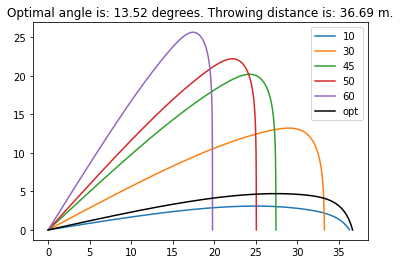

In [12]:
opt_angl = AdaptiveHill()
test_ang = [10,30,45,50,60]


for i in test_ang:
    a = fitness_func(i)
    plt.plot(a[1][:,0],a[1][:,1], label = i)
    
a = fitness_func(opt_angl)
plt.plot(a[1][:,0],a[1][:,1], label = 'opt', color = 'k')
plt.title('Optimal angle is: ' + str(round(opt_angl,2)) +' degrees. Throwing distance is: ' + str(round(a[0],2))+' m.')
plt.legend()
plt.show()